In [1]:
import pandas as pd
import numpy as np
import os, sys
sys.path.insert(0, os.path.abspath('../..'))
import source.data_preparation as dp
import source.modelling as modl
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Example


In [2]:
data = dp.prepare_data()

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [3]:
# Pick the monthly variables you actually have in `data`:
monthly_vars = [
    "vp","impvar","vrp","lzrt","ogap","wtexas","sntm","ndrbL","skvw","tail",
    "fbm","dtoy","dtoat","ygap","rdsp","rsvix","tchi","avgcor","shtint",
    "disag","ntis","tby","lty","ltr","tms","dfy","dfr","infl"
]
monthly_vars = [v for v in monthly_vars if v in data.columns]

ranking = modl.rank_monthly_predictors(
    data,
    monthly_vars=monthly_vars,
    start_date="1927-01-01",
    start_oos="1965-01-01",
    lag=1,
    quiet=True,  # set False to see printed ranking
)


Monthly predictors ranked (worst → best) by OOS R²:
 1.      rsvix   R²_OOS = -0.0713
 2.     impvar   R²_OOS = -0.0594
 3.      disag   R²_OOS = -0.0255
 4.     shtint   R²_OOS = -0.0177
 5.       ntis   R²_OOS = -0.0153
 6.       ygap   R²_OOS = -0.0150
 7.         vp   R²_OOS = -0.0129
 8.       dtoy   R²_OOS = -0.0126
 9.       skvw   R²_OOS = -0.0122
10.        vrp   R²_OOS = -0.0119
11.       rdsp   R²_OOS = -0.0107
12.       tail   R²_OOS = -0.0106
13.        fbm   R²_OOS = -0.0106
14.        dfr   R²_OOS = -0.0103
15.        ltr   R²_OOS = -0.0103
16.       sntm   R²_OOS = -0.0096
17.      dtoat   R²_OOS = -0.0088
18.        tms   R²_OOS = -0.0087
19.     avgcor   R²_OOS = -0.0087
20.        dfy   R²_OOS = -0.0086
21.       lzrt   R²_OOS = -0.0081
22.       tchi   R²_OOS = -0.0070
23.       infl   R²_OOS = -0.0055
24.     wtexas   R²_OOS = -0.0049
25.        lty   R²_OOS = -0.0041
26.       ogap   R²_OOS = -0.0041


[OLS(ogap)] Device=cpu | Valid months=720 | MSE=0.001914 | RMSE=0.043744 | R²_OS=-0.0041


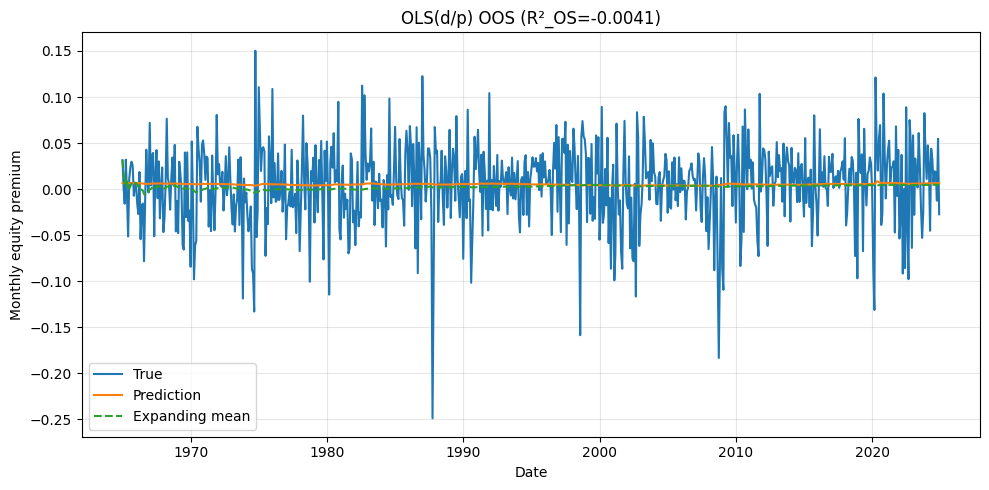

In [5]:
r2_o, y_true_o, y_pred_o, dates_o = modl.ols_oos(data, variables=("ogap",), start_oos="1965-01-01")

modl.plot_oos(
    y_true_o, y_pred_o, dates=dates_o,
    title=f"OLS(d/p) OOS (R²_OS={r2_o:.4f})",
    ylabel="Monthly equity premium"
)


/Users/kilianrunnwerth/Masterarbeit/source/modelling.py:112: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  z = z[~z.index.duplicated(keep="last")].sort_index().asfreq(freq)


[Chronos-Bolt] prediction_length=1, origins=720, first_origin=1965-01-31, last_origin=2024-12-31
[Chronos-Bolt (h=1)] Device=cpu | Valid months=720 | MSE=0.001928 | RMSE=0.043905 | R²_OS=-0.0115


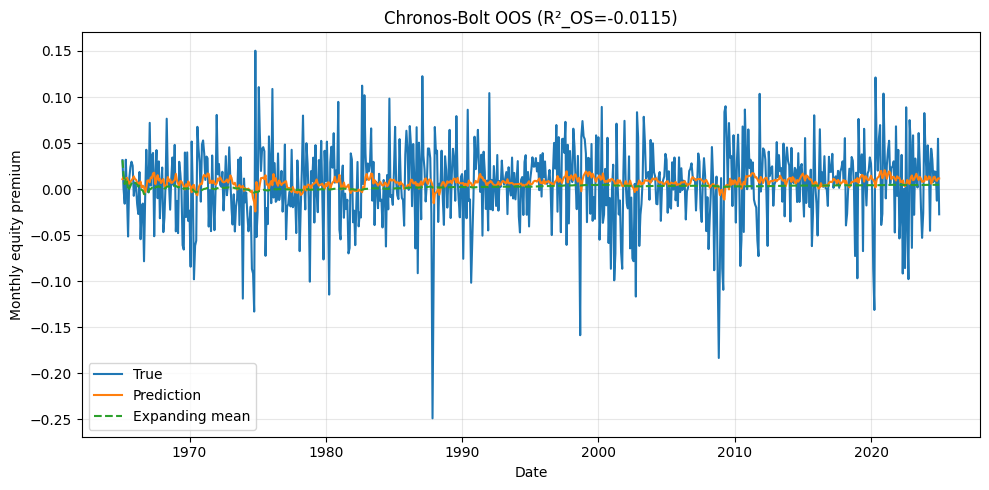

In [13]:
r2_c, y_true_c, y_pred_c, dates_c = modl.chronos_oos(data, start_oos="1965-01-01", quiet=False, ct_cutoff=False, freq='M')

modl.plot_oos(
    y_true_c[1], y_pred_c[1], dates=dates_c[1],
    title=f"Chronos-Bolt OOS (R²_OS={r2_c[1]:.4f})",
    ylabel="Monthly equity premium"
)


[XGB(d/p,e/p,tms,dfy,tbl,ltr,infl,svar,cay)] Device=cpu | Valid months=720 | MSE=0.001935 | RMSE=0.043991 | R²_OS=-0.0155


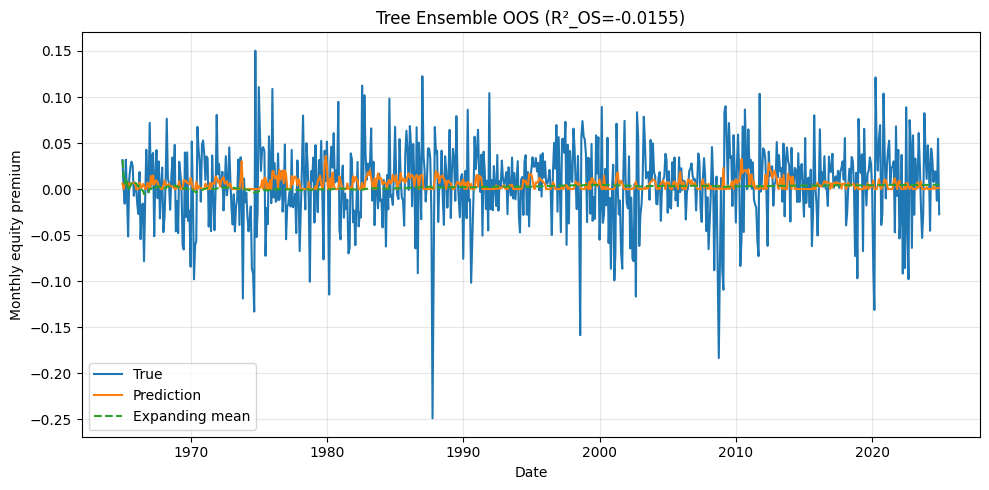

In [14]:
vars_gw = ['d/p','d/y','e/p','tms','dfy','dfr','tbl','ltr','infl','svar','b/m','ntis','cay']
vars_core = ['d/p','e/p','tms','dfy','tbl','ltr','infl','svar','cay']

xgb_params = dict(
    n_estimators=1200, max_depth=2, learning_rate=0.01,
    subsample=0.7, colsample_bytree=0.7, reg_lambda=2.0,
    objective="reg:squarederror", random_state=42
)
# r2_te, y_true_te, y_pred_te, dates_te = modl.tree_ensemble_oos(data, vars_core, model_params=xgb_params, ct_cutoff=True)
# print("Tree ensemble OOS R²:", r2)
# # choose some variables you have
# vars_for_tree = ["tms","dfy","ntis"]

# modl.plot_oos(
#     y_true_te, y_pred_te, dates=dates_te,
#     title=f"Tree Ensemble OOS ({','.join(vars_for_tree)})  R²_OS={r2_te:.4f}",
#     ylabel="Monthly equity premium"
# )
r2_t, y_true_t, y_pred_t, dates_t = modl.tree_ensemble_oos(data, variables=vars_core, ct_cutoff=True, model_params=xgb_params)
    
modl.plot_oos(
    y_true_t, y_pred_t, dates=dates_t,
    title=f"Tree Ensemble OOS (R²_OS={r2_t:.4f})",
    ylabel="Monthly equity premium"
)

/Users/kilianrunnwerth/Masterarbeit/source/modelling.py:112: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  z = z[~z.index.duplicated(keep="last")].sort_index().asfreq(freq)
INFO:p-1321:t-8800067776:timesfm_2p5_torch.py:_from_pretrained:Downloading checkpoint from Hugging Face repo google/timesfm-2.5-200m-pytorch


[TimesFM] Using device hint: mps


INFO:p-1321:t-8800067776:timesfm_2p5_torch.py:_from_pretrained:Loading checkpoint from: /Users/kilianrunnwerth/.cache/huggingface/hub/models--google--timesfm-2.5-200m-pytorch/snapshots/1d952420fba87f3c6dee4f240de0f1a0fbc790e3/model.safetensors


[TimesFM] prediction_length=1, origins=196, first_origin=2008-09-30, last_origin=2024-12-31
[TimesFM (h=1)] Device=cpu | Valid months=196 | MSE=0.002148 | RMSE=0.046348 | R²_OS=-0.0618


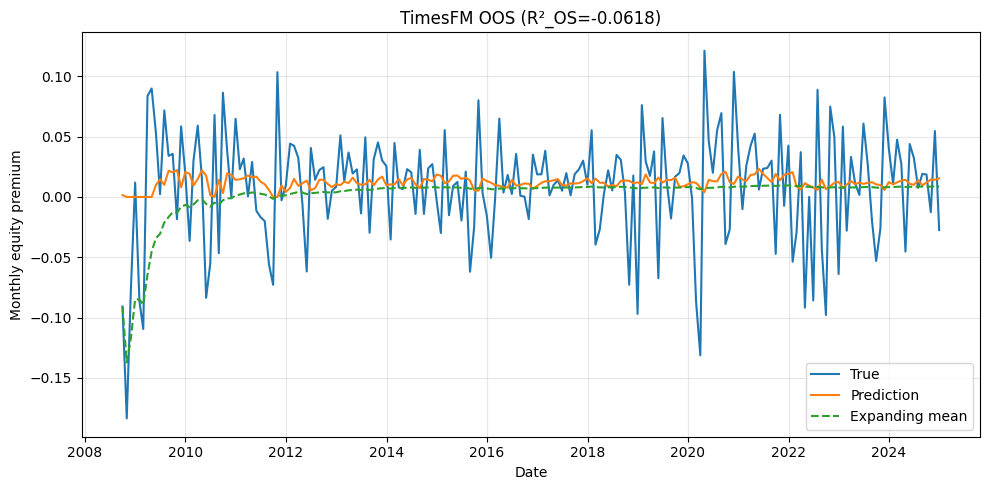

In [19]:


r2_tf, y_true_tf, y_pred_tf, dates_tf = modl.timesfm_oos(
    data, start_oos="2008-09-01", min_context=120, max_context=512, ct_cutoff=True, quiet=False, freq="M",
)

modl.plot_oos(
    y_true_tf[1], y_pred_tf[1], dates=dates_tf[1],
    title=f"TimesFM OOS (R²_OS={r2_tf[1]:.4f})",
    ylabel="Monthly equity premium"
)


[Moirai2] Using freq='M' (month-end) | ctx=240 | H=1


/Users/kilianrunnwerth/Masterarbeit/source/modelling.py:760: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.sort_index().asfreq(FREQ_STR)


[Moirai 2 (reinstantiated each step)] prediction_length=1, origins=720, first_origin=1965-01-31, last_origin=2024-12-31


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/gluonts/dataset/common.py:254: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),


[Moirai 2 (reinstantiated each step) (h=1)] Device=cpu | Valid months=720 | MSE=0.001945 | RMSE=0.044107 | R²_OS=-0.0208


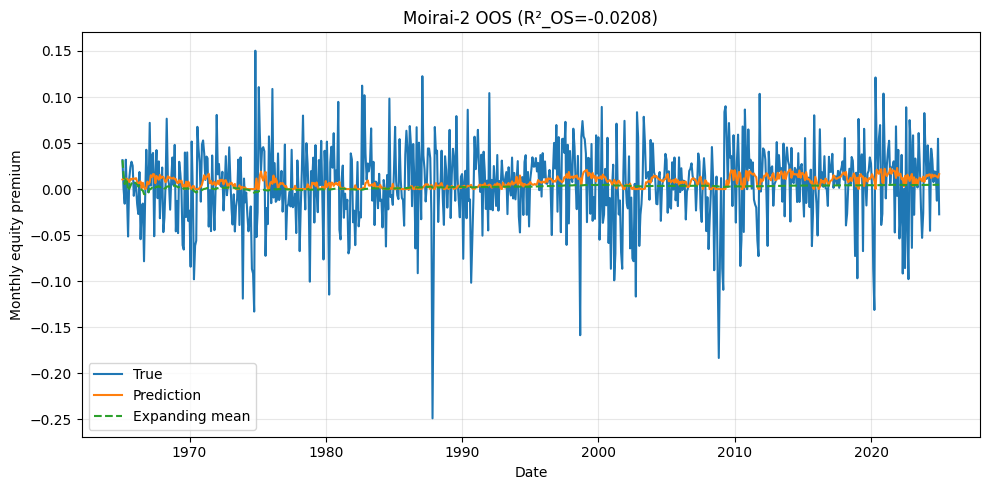

In [26]:
r2_m, y_true_m, y_pred_m, dates_m = modl.moirai2_oos(
    data, covariates=(), start_oos="1965-01-01",
    ctx=240, device="cpu", ct_cutoff=True, quiet=False
)

modl.plot_oos(
    y_true_m[1], y_pred_m[1], dates=dates_m[1],
    title=f"Moirai-2 OOS (R²_OS={r2_m[1]:.4f})",
    ylabel="Monthly equity premium"
)

[Moirai2] Using freq='M' (month-end) | ctx=240 | H=1


/Users/kilianrunnwerth/Masterarbeit/source/modelling.py:760: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.sort_index().asfreq(FREQ_STR)


[Moirai 2 (reinstantiated each step)] prediction_length=1, origins=720, first_origin=1965-01-31, last_origin=2024-12-31


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/gluonts/dataset/common.py:254: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),


[Moirai 2 (reinstantiated each step) (h=1)] Device=cpu | Valid months=720 | MSE=0.002308 | RMSE=0.048046 | R²_OS=-0.2113


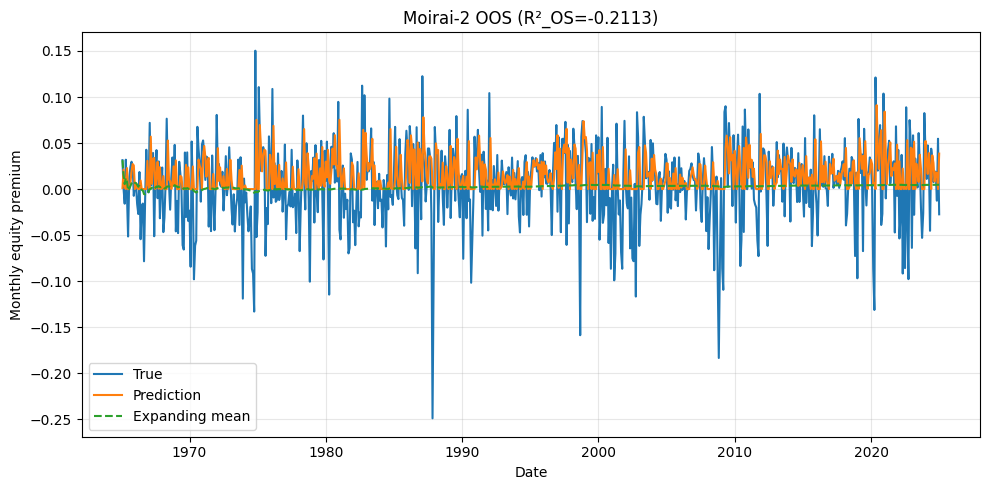

In [27]:
r2_m, y_true_m, y_pred_m, dates_m = modl.moirai2_oos(
    data, covariates=("d/p","tms","dfy"), start_oos="1965-01-01",
    ctx=240, device="cpu", ct_cutoff=True, quiet=False
)

modl.plot_oos(
    y_true_m[1], y_pred_m[1], dates=dates_m[1],
    title=f"Moirai-2 OOS (R²_OS={r2_m[1]:.4f})",
    ylabel="Monthly equity premium"
)

In [29]:


r2, y_true, y_pred, dates_fs = modl.flowstate_oos(
    data,
)

/Users/kilianrunnwerth/Masterarbeit/source/modelling.py:677: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  z = z[~z.index.duplicated(keep="last")].sort_index().asfreq(f)
INFO:p-1321:t-8800067776:modeling_flowstate.py:__init__:Number of encoder parameters: 7885.8240000000005k
INFO:p-1321:t-8800067776:modeling_flowstate.py:__init__:Number of dencoder parameters: 1181.952k (14.99%)


[FlowState (expanding)] prediction_length=1, origins=720, first_origin=1965-01-31, last_origin=2024-12-31
[FlowState (expanding) (h=1)] Device=cpu | Valid months=720 | MSE=0.002004 | RMSE=0.044767 | R²_OS=-0.0516


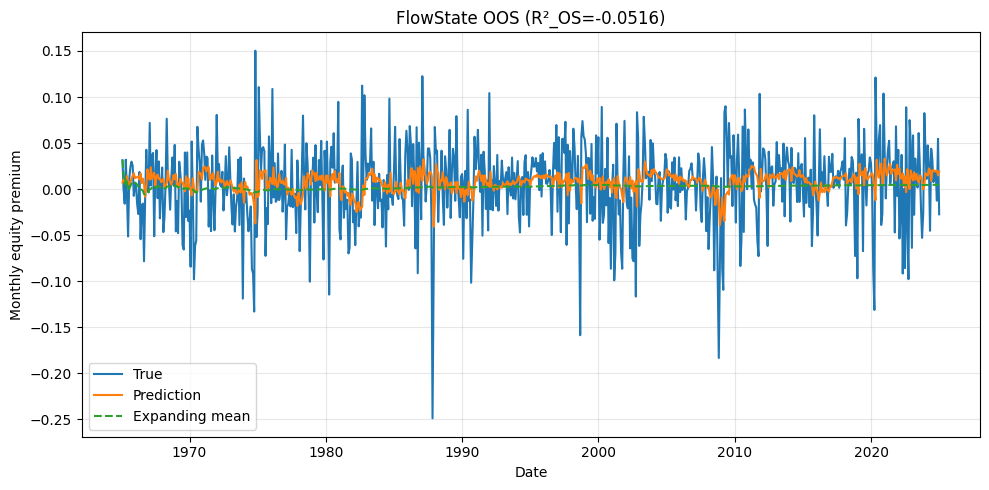

In [30]:
modl.plot_oos(
    y_true[1],
    y_pred[1],
    dates=dates_fs[1],
    title=f"FlowState OOS (R²_OS={r2[1]:.4f})",
    ylabel="Monthly equity premium",
)

In [12]:
r2_tabpfn, y_true_tabpfn, y_pred_tabpfn, dates_tabpfn = tabpfn_oos_fit_each_step(
    data,
    variables=("d/p","tms","dfy"),
    start_oos="1965-01-01",
    lag=1,
    min_train=120,
    ct_cutoff=False,
    quiet=False,
    model_params={"N_ensemble_configurations":8},
)

plot_oos(
    y_true_tabpfn, y_pred_tabpfn, dates=dates_tabpfn,
    title=f"TabPFN (fit each step) OOS (R²_OS={r2_tabpfn:.4f})",
    ylabel="Monthly equity premium"
)


NameError: name 'tabpfn_oos_fit_each_step' is not defined

In [ ]:
r2_pfn_ts, y_true_pfn_ts, y_pred_pfn_ts, dates_pfn_ts = tabpfn_ts_oos_fit_each_step(
    data,
    target_col="equity_premium",
    start_oos="1965-01-01",
    ctx=240,
    freq="M",
    min_windows=120,
    ct_cutoff=False,
    quiet=False,
    fit_kwargs={"epochs": 1}  # if your build supports epochs
)

plot_oos(
    y_true_pfn_ts, y_pred_pfn_ts, dates=dates_pfn_ts,
    title=f"TabPFN-TS (fit each step) OOS (R²_OS={r2_pfn_ts:.4f})",
    ylabel="Monthly equity premium"
)
